Here we will build prediction model based on the data produced at the ETL stage. We will compare:
- naive baseline, simply a mean of y_train
- baseline, which will be a linear model based on 1 feature "number_of_panels_total"
- linear model with all the rest features + regularisation 
- linear model with all features + polynomial features + regularisation 
- random forest
- adaboost
- xgboost
- ensamble of best models

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
import category_encoders as ce

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.base import BaseEstimator
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures


# Data initiation

In [3]:
raw_df =  pd.read_csv('datasets/geo_solar_panels.csv').dropna().reset_index(drop=True) # raw df without any additional feats
prescaled_df = pd.read_csv('datasets/prescaled_modeling_df.csv')# eda feats before manual scaling
scaled_df = pd.read_csv('datasets/scaled_modeling_df.csv')# manually scaled, eda feats
small_df = pd.read_csv('datasets/small_modeling_df.csv')  # standardized, eda feats only
transformed_df = pd.read_csv('datasets/modeling_df.csv')  # standardized, eda feats + scikit transformed feats

trans_label = 'scaled_label'
small_label = 'scaled_potential_kwh_total'
raw_label = scaled_label = prescaled_label = 'potential_kwh_total'

# Naive baseline

In [4]:
def norm_rmse(estimator, X_test, y_test):
    y_pred = estimator.predict(X_test)
    naive_baseline_rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
    return {'nrmse': naive_baseline_rmse / np.std(y_test),#.values[0], 
            'r2': r2_score(y_pred=y_pred, y_true=y_test)}

class NaiveEstimator(BaseEstimator):

    def fit(self, X_train, Y_train):
        self.fitted_mean = Y_train.mean()

    def predict(self, X_test):
        return np.array([self.fitted_mean] * X_test.shape[0])

In [5]:
kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(NaiveEstimator(), 
                          X=raw_df[['number_of_panels_total']].values, 
                          y=raw_df[[raw_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") #

NRMSE: 1.0002873776217482
 R2: -0.000575017225807334


# Baseline model

## Single feature

In [6]:
kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(linear_model.LinearRegression(positive=True), 
                          X=raw_df[['number_of_panels_total']].values, 
                          y=raw_df[[raw_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") #

NRMSE: 0.16052719148939235
 R2: 0.9742167833528951


In [7]:
kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(linear_model.LinearRegression(), 
                          X=scaled_df[['number_of_panels_total']].values, 
                          y=scaled_df[[scaled_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") #

NRMSE: 0.1605384010771596
 R2: 0.9742120393470688


Baseline model is much better, than naive baseline and is only about 17% of label std, about 13% of iqr and very high r2 score. It will probably be hard to beat.

## Extended

In [8]:
ext_base_df = raw_df.copy()
ext_base_df.loc[:, 'state'] = ce.LeaveOneOutEncoder().fit_transform(raw_df['state'], raw_df[raw_label])

kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(linear_model.LinearRegression(positive=True), 
                          X=ext_base_df[[col for col in list(ext_base_df) if col!=raw_label]].values, 
                          y=ext_base_df[[raw_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") #

NRMSE: 0.13333563656892586
 R2: 0.9822102420124722


In [9]:
kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(linear_model.LinearRegression(), 
                          X=scaled_df[[col for col in list(scaled_df) if col!=scaled_label]].values, 
                          y=scaled_df[[scaled_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") #

NRMSE: 0.153183960533637
 R2: 0.9740255313417301


In [12]:
kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(linear_model.LinearRegression(), 
                          X=transformed_df[[col for col in list(transformed_df) if col!=trans_label]].values * 10, 
                          y=transformed_df[[trans_label]].values * 10, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") #

NRMSE: 0.17379038157507715
 R2: 0.9551807594547972


Interestingly, the fewer features there is in the df here, the better the score

# Linear model + regularisation

In [214]:
ext_base_df = raw_df.copy()
ext_base_df.loc[:, 'state'] = ce.LeaveOneOutEncoder().fit_transform(raw_df['state'], raw_df[raw_label])

kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(Lasso(),
                          X=ext_base_df[[col for col in list(ext_base_df) if col!=raw_label]].values, 
                          y=ext_base_df[[raw_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") 

/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e+18, tolerance: 1.613e+16
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.312e+18, tolerance: 1.593e+16
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You

NRMSE: 0.1277739280308097
 R2: 0.9836627786775979


/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+18, tolerance: 1.599e+16
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e+18, tolerance: 1.576e+16
  model = cd_fast.enet_coordinate_descent(


In [216]:
kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(ElasticNet(),
                          X=scaled_df[[col for col in list(scaled_df) if col!=scaled_label]].values, 
                          y=scaled_df[[scaled_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") 

NRMSE: 0.13303573343804928
 R2: 0.9822895905968774


In [225]:
kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(ElasticNet(), 
                          X=small_df[[col for col in list(small_df) if col!=small_label]].values * 15, 
                          y=small_df[[small_label]].values * 15, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") #

NRMSE: 0.13338597872831642
 R2: 0.9821964097503669


In [14]:
kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(ElasticNet(), 
                          X=transformed_df[[col for col in list(transformed_df) if col!=trans_label]].values * 15, 
                          y=transformed_df[[trans_label]].values * 15, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") #

NRMSE: 0.12968628800573856
 R2: 0.9831658071193765


Once we add regularisation, the score comes back to simple model without additional features, so regularisation works well for selecting better features even for the dataset with most number of features (last cell). In fact latter gives better result. That means more elaborate feature selection process might make sense.

# Linear model + regularisation + polinomial features

In [18]:
poly = PolynomialFeatures(2)
poly_data = poly.fit_transform(ext_base_df[[col for col in list(ext_base_df) if col!=raw_label]])


kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(ElasticNet(),
                          X=poly_data, 
                          y=ext_base_df[[raw_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") 

/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e+17, tolerance: 1.599e+16
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.698e+17, tolerance: 1.592e+16
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You

NRMSE: 0.06862854993668545
 R2: 0.995282460764711


/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e+17, tolerance: 1.592e+16
  model = cd_fast.enet_coordinate_descent(


In [19]:
poly = PolynomialFeatures(2)
poly_data = poly.fit_transform(scaled_df[[col for col in list(scaled_df) if col!=scaled_label]])

kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(ElasticNet(),
                          X=poly_data, 
                          y=scaled_df[[scaled_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") 

/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.031e+05, tolerance: 3.961e+03
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.066e+05, tolerance: 4.069e+03
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You

NRMSE: 0.08430642762263593
 R2: 0.9908482859574672


/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e+05, tolerance: 4.001e+03
  model = cd_fast.enet_coordinate_descent(


In [22]:
poly = PolynomialFeatures(2)
poly_data = poly.fit_transform(small_df[[col for col in list(small_df) if col!=small_label]] * 10)

kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(ElasticNet(),
                          X=poly_data, 
                          y=small_df[[small_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") 

/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.005e+02, tolerance: 5.298e-01
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.990e+02, tolerance: 5.238e-01
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You

In [21]:
poly = PolynomialFeatures(2)
poly_data = poly.fit_transform(transformed_df[[col for col in list(transformed_df) if col!=trans_label]])

kfold = RepeatedKFold(n_splits=5, n_repeats=100)
test_res = cross_validate(ElasticNet(),
                          X=poly_data, 
                          y=transformed_df[[trans_label]].values, 
                          scoring = norm_rmse,
                          cv=kfold)
print(f"NRMSE: {test_res['test_nrmse'].mean()}\n R2: {test_res['test_r2'].mean()}") 

/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.979e+00, tolerance: 5.322e-01
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e+00, tolerance: 5.351e-01
  model = cd_fast.enet_coordinate_descent(
/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You

KeyboardInterrupt: 

Score is improved further by adding polinomial features. Let's look at the feature importance graph again

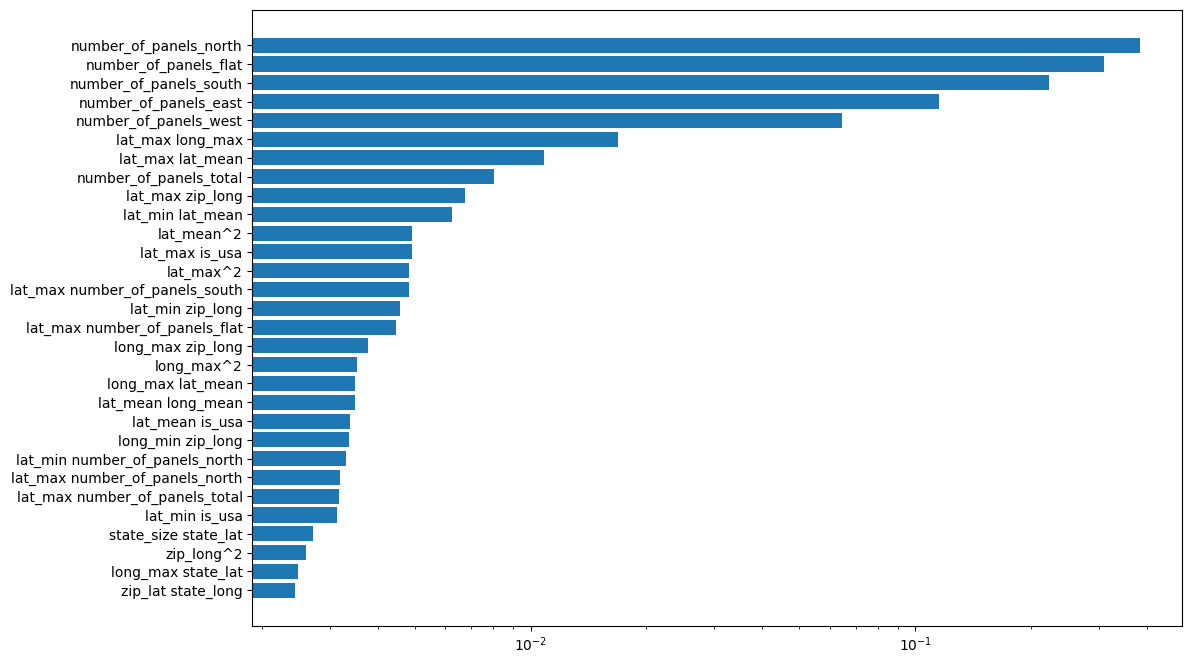

In [239]:
plt.figure(figsize=[12,8])
feat_imp_df = pd.DataFrame(zip(poly.get_feature_names_out(), baseline_model.coef_)).set_index(0).abs().sort_values(1, ascending=False)[:30].sort_values(1)
plt.barh(feat_imp_df.index, feat_imp_df[1])
plt.xscale('log')

# Random forest

## Init df

In [262]:
X_train, X_test, y_train, y_test = train_test_split(poly_data, df[[label]].values, test_size=.2)
rand_forest = RandomForestRegressor(110, max_depth=8, min_samples_leaf=5)

In [263]:
rand_forest.fit(X_train, y_train)


/var/folders/p3/4j53xc_50yv4yqz952bnybrm0000gn/T/ipykernel_89689/3874118985.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rand_forest.fit(X_train, y_train)


RandomForestRegressor(max_depth=8, min_samples_leaf=5, n_estimators=110)

In [264]:
y_pred = rand_forest.predict(X_test)

In [265]:
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
rmse

5.718790908663191

## Polynomial features

In [271]:
poly = PolynomialFeatures(3)
poly_data = poly.fit_transform(df[all_feats])

In [272]:
X_train, X_test, y_train, y_test = train_test_split(poly_data, df[[label]].values, test_size=.2)

rand_forest = RandomForestRegressor(110, max_depth=8, min_samples_leaf=5)
rand_forest.fit(X_train, y_train)
y_pred = rand_forest.predict(X_test)


/var/folders/p3/4j53xc_50yv4yqz952bnybrm0000gn/T/ipykernel_89689/2132379075.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rand_forest.fit(X_train, y_train)


In [273]:
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
rmse

4.812392045545897

# AdaBoost

In [289]:
X_train, X_test, y_train, y_test = train_test_split(poly_data, df[[label]].values, test_size=.2)
ada_forest = AdaBoostRegressor(n_estimators=20)


In [290]:
ada_forest.fit(X_train, y_train)


/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(n_estimators=20)

In [291]:
y_pred = ada_forest.predict(X_test)

In [292]:
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
rmse

11.10975035259361

# XGBoost

In [300]:
X_train, X_test, y_train, y_test = train_test_split(poly_data, df[[label]].values, test_size=.2)
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [301]:
y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
rmse

3.819197880504882

So far we see that when regularisation is applied and additional polynomial features are added, regardless of the prediction algo, results are much better.